# Python for Creating CSV and Preliminary Reporting

In [2]:
import csv
import contextily as cx
import geopandas as gpd
import hvplot.pandas as hpd
import json
import matplotlib.pyplot as plt
import pandas as pd
import rdflib as rdf
from shapely.geometry import Point
import urllib



#import geopandas as gpd

%matplotlib inline
plt.style.use('ggplot')

from datetime import date
print("Last run: ", date.today())

#gv.extension('bokeh', 'matplotlib')

Last run:  2023-05-25


## Load Data and Write to CSV


In [3]:
with open("roman-amphitheaters.geojson") as f:
    j = json.load(f)

In [4]:
# If there is one, I'd welcome a more pythonic approach. One that 
# accomodates the variable data model supported by JSON.

d = []
for feature in j['features']:
    
    # Check for optional properties

    latintoponym = ''
    if 'latintoponym' in feature['properties'].keys():
        latintoponym = feature['properties']['latintoponym']
            
    welchid = ''
    if 'welchid' in feature['properties'].keys():
        welchid = feature['properties']['welchid']
        
    golvinid = ''
    if 'golvinid' in feature['properties'].keys():
        golvinid = feature['properties']['golvinid']

    buildingtype = ''
    if 'buildingtype' in feature['properties'].keys():
        buildingtype = feature['properties']['buildingtype']
            
    try:
        zotero = feature['properties']['bibliography'][0]['zoteroitem']
    except:
        zotero = ''

    amphitheatrum = ''
    if 'amphitheatrum' in feature['properties'].keys():
        amphitheatrum = feature['properties']['amphitheatrum']
 
    chronogroup = ''
    if 'chronogroup' in feature['properties'].keys():
        chronogroup = feature['properties']['chronogroup']
        
    secondcentury = True
    if 'exclude' in feature['properties'].keys():
        secondcentury = False

    capacity = ''
    if 'capacity' in feature['properties'].keys():
        if 'quantity' in feature['properties']['capacity']:
            capacity = feature['properties']['capacity']['quantity']


    romanregion = ''
    if 'province' in feature['properties'].keys():
        romanregion = feature['properties']['province']
    elif 'region' in feature['properties'].keys():
        romanregion = feature['properties']['region']
        
        
    arenamajor = ''
    arenaminor = ''
    extmajor = ''
    extminor = ''
    exteriorheight = ''
    dimensionsunknown = True
    if 'dimensions' in feature['properties'].keys():
        dimensions = feature['properties']['dimensions']
        
        if 'arenamajor' in dimensions:
            if type(dimensions['arenamajor']) == int or type(dimensions['arenamajor']) == float:
                arenamajor = dimensions['arenamajor']
                dimensionsunknown = False

        if 'arenaminor' in dimensions:
            if type(dimensions['arenaminor']) == int or type(dimensions['arenaminor']) == float:
                arenaminor = dimensions['arenaminor']
                dimensionsunknown = False
            
        if 'exteriormajor' in dimensions:
            if type(dimensions['exteriormajor']) == int or type(dimensions['exteriormajor']) == float:
                extmajor = dimensions['exteriormajor']
                dimensionsunknown = False

        if 'exteriorminor' in dimensions:
            if type(dimensions['exteriorminor']) == int or type(dimensions['exteriorminor']) == float:
                extminor = dimensions['exteriorminor']
                dimensionsunknown = False
            
        if 'exteriorheight' in dimensions:
            if type(dimensions['exteriorheight']) == int or type(dimensions['exteriorheight']) == float:
                exteriorheight = dimensions['exteriorheight']
      
    d.append((feature['id'],
              feature['properties']['title'],
              feature['properties']['label'],
              latintoponym,
              feature['properties']['pleiades'],
              welchid,
              golvinid,
              buildingtype,
              chronogroup,
              secondcentury,
              capacity,
              feature['properties']['moderncountry'],
              romanregion,
              zotero,
              amphitheatrum,
              dimensionsunknown,
              arenamajor,
              arenaminor,
              extmajor,
              extminor,
              exteriorheight,
              feature['geometry']['coordinates'][0],
              feature['geometry']['coordinates'][1],
              feature['geometry']['coordinates'][2]))

ramphs_df = pd.DataFrame(d, columns=(
 'id',    # short id
 'title', # longer title
 'label', # short label
 'latintoponym', # latin toponym
 'pleiades', # pleiades https uri
 'welchid',  # id in Welch
 'golvinid', # id in Golvin
 'buildingtype',  # usually 'amphitheater'
 'chronogroup',   # label for the chronological group
 'secondcentury', # is this an amphitheater that was in use in 2nd century
 'capacity',    # capacity as integer
 'modcountry',  # modern country
 'romanregion', # province or augustan region of italy
 'zotero',      # zotero item id
 'amphitheatrum', # amphitheatrum url
 'dimensionsunknown', # if true, that's a direct statement that no dimensions are available
 'arenamajor', # long axis of arena in meters
 'arenaminor', # short axis of arena in meters
 'extmajor',   # long axis of exterior
 'extminor', # short axis of exterior
 'exteriorheight',   # height of exterior wall if known
 'longitude', # longitude
 'latitude', # latitude
 'elevation'  # elevation in meters.
 )) 

ramphs_df[['capacity','elevation','arenamajor','arenaminor',
        'extmajor','extminor','exteriorheight']] = ramphs_df[['capacity','elevation','arenamajor',
        'arenaminor','extmajor','extminor','exteriorheight']].apply(pd.to_numeric)

In [5]:
ramphs_df.to_csv("roman-amphitheaters.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

## Basic Mapping

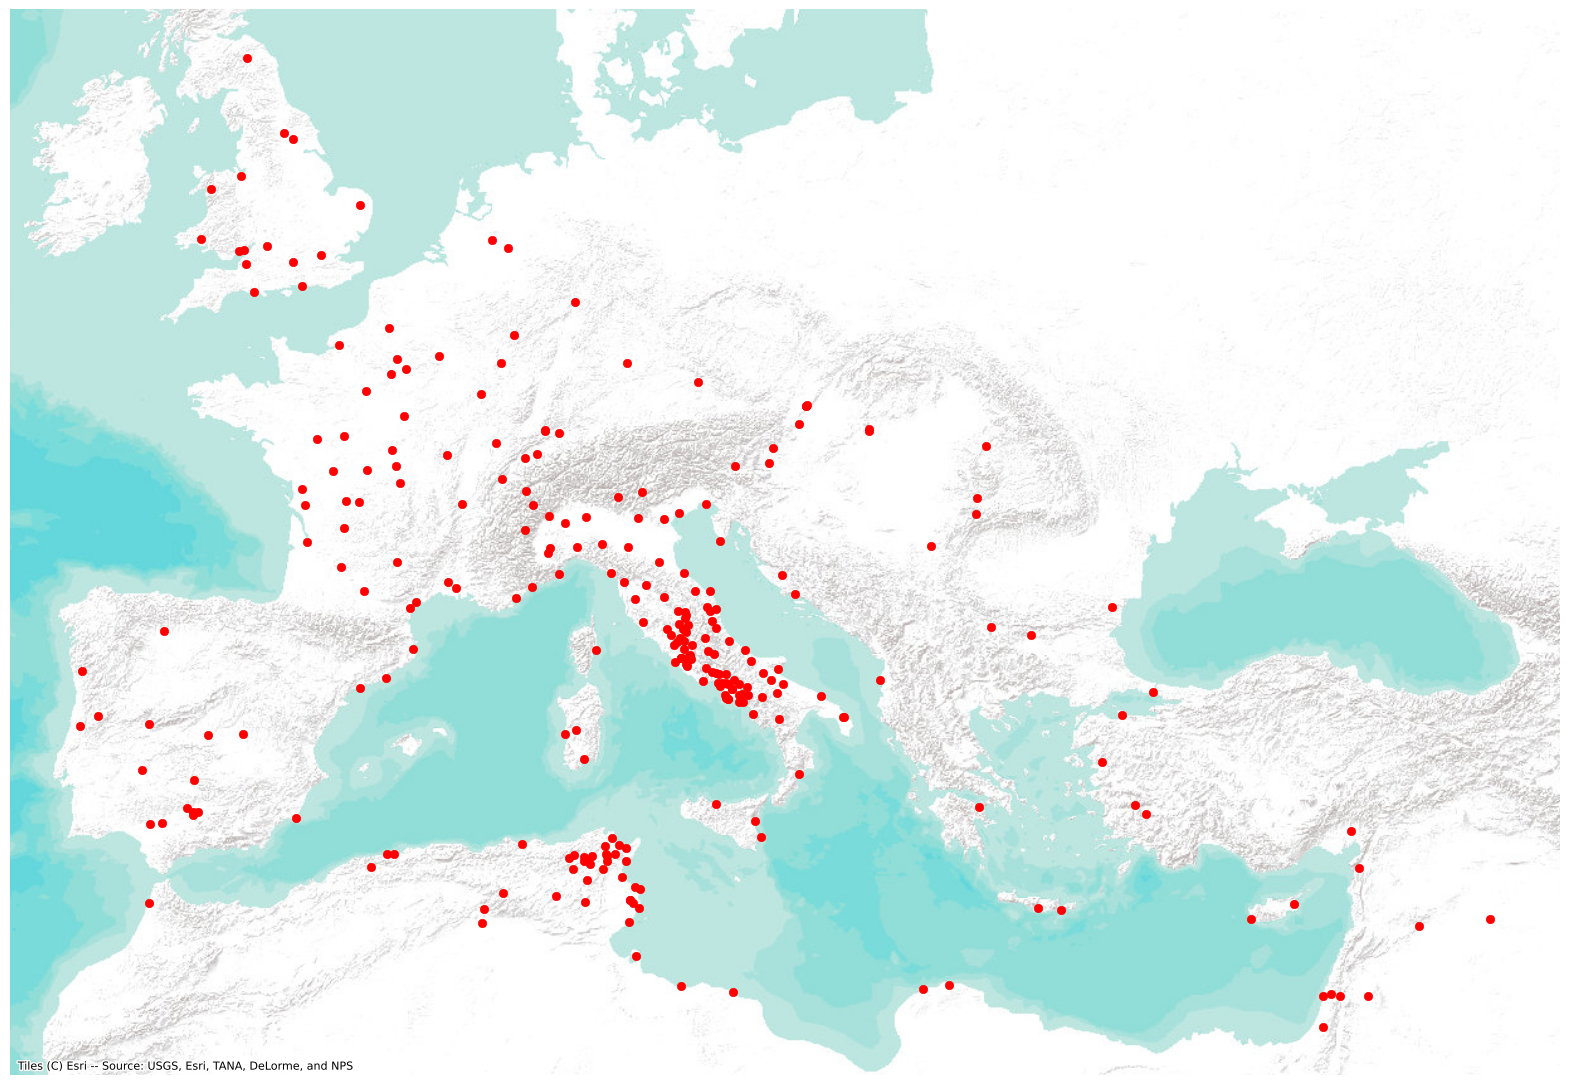

In [15]:
ramphs_gdf = gpd.read_file("roman-amphitheaters.geojson")

ramphs_gdf_epsg3857 = ramphs_gdf.to_crs(3857)

ax = ramphs_gdf_epsg3857.plot(figsize=(20, 20), color = 'red')
cx.add_basemap(ax, source=cx.providers.Esri.WorldTerrain)

ax.set_axis_off()
plt.savefig("all-roman-amphitheaters-map.png",pad_inches=0, bbox_inches='tight')

In [16]:
# interactive version
tb = ramphs_gdf_epsg3857.total_bounds

hv = ramphs_gdf_epsg3857.hvplot(global_extent=False,
                          
                           hover_cols = ['id'],
                           tiles='EsriTerrain',
                           xticks = 0, yticks = 0,
                           xlim = (tb[0]-300000,tb[2]),
                           ylim = (tb[1]-300000,tb[3]+300000),
                           height = 500,
                           width = 700,
                                c = 'red'
                           )


hv

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [x,y]   (id)

In [17]:
# with roman territory using geopandas


url = "http://sebastianheath.com/roman-maps/roman_empire_ad_200_extent.geojson" # at some point update geojson source
borders_gdf = gpd.read_file(url)

base = borders_gdf.plot(color = 'black', figsize = (40,24))
ramphs_gdf.plot(ax = base, color = 'red', markersize = 100)

plt.grid(False)
plt.axis('off')

plt.savefig('all-roman-amphitheaters-map-dark.png',pad_inches=0, bbox_inches='tight', transparent = True)
plt.close()

## Basic/Various Reporting

This is semi-random / redundant code by which I keep on top of data entry...

In [18]:
ramphs_df.head(2)

,id,title,label,latintoponym,pleiades,welchid,golvinid,buildingtype,chronogroup,secondcentury,...,amphitheatrum,dimensionsunknown,arenamajor,arenaminor,extmajor,extminor,exteriorheight,longitude,latitude,elevation
0,duraEuroposAmphitheater,Amphitheater at Dura Europos,Dura,Dura Europus,https://pleiades.stoa.org/places/893989,,129,amphitheater,severan,False,...,http://amphi-theatrum.de/1449.html,False,31.0,25.0,50.0,44.0,NaN,40.728926,34.749855,223
1,arlesAmphitheater,Amphitheater at Arles,Arles,Arelate,https://pleiades.stoa.org/places/148217,,154,amphitheater,flavian,True,...,http://amphi-theatrum.de/1371.html,False,47.0,32.0,136.0,107.0,NaN,4.631111,43.677778,21


In [19]:
ramphs_df.describe()

,capacity,arenamajor,arenaminor,extmajor,extminor,exteriorheight,longitude,latitude,elevation
count,153.000000,183.000000,178.000000,216.000000,197.000000,3.000000,272.000000,272.000000,272.000000
mean,12431.307190,56.639672,38.439775,96.050370,77.582030,41.483333,10.533948,42.229250,197.738971
std,9115.064708,14.340172,8.793810,30.767761,25.213482,9.859048,9.045853,4.912640,211.015822
min,1000.000000,25.000000,19.000000,25.000000,31.000000,32.450000,-8.493330,31.608189,-121.000000
25%,5831.000000,46.900000,32.175000,74.000000,59.400000,36.225000,5.325859,38.480299,34.750000
50%,10000.000000,58.000000,39.000000,92.900000,75.000000,40.000000,10.954128,42.089044,123.500000
75%,17000.000000,66.000000,43.000000,114.250000,94.500000,46.000000,14.144132,45.524757,291.250000
max,50000.000000,104.000000,74.000000,189.000000,156.000000,52.000000,40.728926,55.602600,1170.000000


In [20]:
ramphs_df[ramphs_df.secondcentury].describe()

,capacity,arenamajor,arenaminor,extmajor,extminor,exteriorheight,longitude,latitude,elevation
count,143.000000,173.000000,168.000000,204.000000,187.000000,2.000000,250.000000,250.000000,250.000000
mean,12254.209790,56.678092,38.582024,95.835196,77.568770,42.225000,10.018970,42.338104,198.172000
std,9055.199652,14.463537,8.879051,29.746020,25.049908,13.823938,8.837994,4.960701,211.198508
min,1248.000000,25.000000,19.000000,25.000000,31.000000,32.450000,-8.493330,31.608189,1.000000
25%,5615.500000,46.800000,32.525000,74.375000,59.700000,37.337500,4.091795,38.686097,35.750000
50%,9770.000000,58.000000,39.100000,92.400000,75.000000,42.225000,10.606566,42.270997,125.500000
75%,16024.500000,66.000000,43.050000,113.775000,94.250000,47.112500,14.042726,45.692934,289.500000
max,50000.000000,104.000000,74.000000,189.000000,156.000000,52.000000,38.273763,55.602600,1170.000000


In [21]:
# Confirm that CSV is readable
# It would be nice if the "numeric pattern" string survived as strings.
pd.read_csv("roman-amphitheaters.csv", quoting = 2).describe()

,welchid,golvinid,capacity,arenamajor,arenaminor,extmajor,extminor,exteriorheight,longitude,latitude,elevation
count,19.000000,166.000000,153.000000,183.000000,178.000000,216.000000,197.000000,3.000000,272.000000,272.000000,272.000000
mean,10.105263,100.578313,12431.307190,56.639672,38.439775,96.050370,77.582030,41.483333,10.533948,42.229250,197.738971
std,5.724166,58.199369,9115.064708,14.340172,8.793810,30.767761,25.213482,9.859048,9.045853,4.912640,211.015822
min,1.000000,2.000000,1000.000000,25.000000,19.000000,25.000000,31.000000,32.450000,-8.493330,31.608189,-121.000000
25%,5.500000,54.250000,5831.000000,46.900000,32.175000,74.000000,59.400000,36.225000,5.325859,38.480299,34.750000
50%,10.000000,103.500000,10000.000000,58.000000,39.000000,92.900000,75.000000,40.000000,10.954128,42.089044,123.500000
75%,15.500000,145.750000,17000.000000,66.000000,43.000000,114.250000,94.500000,46.000000,14.144132,45.524757,291.250000
max,19.000000,298.000000,50000.000000,104.000000,74.000000,189.000000,156.000000,52.000000,40.728926,55.602600,1170.000000


In [22]:
# which have heights
ramphs_df[ramphs_df.exteriorheight > 0]

,id,title,label,latintoponym,pleiades,welchid,golvinid,buildingtype,chronogroup,secondcentury,...,amphitheatrum,dimensionsunknown,arenamajor,arenaminor,extmajor,extminor,exteriorheight,longitude,latitude,elevation
4,romeFlavianAmphitheater,Flavian Amphitheater at Rome,Flavian Amphitheater,,https://pleiades.stoa.org/places/423025,,152,amphitheater,flavian,True,...,https://www.amphi-theatrum.de/1373.html,False,83.00,48.00,189.00,156.0,52.00,12.492269,41.890169,22
91,thysdrusAmphitheater,Amphitheater at Thysdrus,Thysdrus (lg.),,https://pleiades.stoa.org/places/324835,,186,amphitheater,post-severan,False,...,,False,65.00,39.00,148.00,122.0,40.00,10.706939,35.296390,111
98,pulaAmphitheater,Amphitheater at Pula,Pula,Colonia Pietas Iulia Pola Pollentia Herculanea,https://pleiades.stoa.org/places/197448,,151,amphitheater,julio-claudian,True,...,,False,67.95,41.65,132.45,105.1,32.45,13.850243,44.873229,16


In [23]:
# which don't have exteriormajor
ramphs_df[pd.isnull(ramphs_df.extmajor)].sort_values(by = 'longitude')\
[['id','modcountry','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

,id,modcountry,latintoponym,golvinid,extmajor,arenamajor,latitude,longitude
159,bragaAmphitheater,Portugal,Bracara Augusta,,NaN,NaN,41.546669,-8.430075
169,bobadelaAmphitheater,Portugal,Elbocoris,,NaN,50.0,40.361088,-7.893572
56,lixusAmphitheater,Morocco,Lixus,,NaN,34.0,35.199900,-6.108468
122,caparraAmphitheater,Spain,Municipium Flavium Caparense,,NaN,30.0,40.164159,-6.100049
197,espejoAmphitheater,Spain,Ucubi,11,NaN,35.0,37.683989,-4.554198
160,sisapoAmphitheater,Spain,,,NaN,NaN,38.645833,-4.516667
270,toledoAmphitheater,Spain,Toletum,,NaN,NaN,39.865349,-4.022888
69,aldburoughAmphitheater,United Kingdom,Isurium Brigantium,,NaN,58.0,54.088116,-1.379630
258,yorkAmphitheater,United Kingdom,Eboracum,,NaN,NaN,53.958333,-1.080278
261,chichesterAmphitheater,United Kingdom,Noviomagus Reginorum,35,NaN,56.0,50.835394,-0.771186


In [24]:
ramphs_df[ramphs_df.golvinid == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

,id,latintoponym,golvinid,extmajor,arenamajor,latitude,longitude
3,ludusMagnusArena,Ludus Magnus,,NaN,NaN,41.889950,12.494913
6,eleutheropolisAmphitheater,Eleutheropolis,,71.0,47.0,31.608189,34.893845
9,newsteadAmphitheater,Trimontium,,70.0,37.0,55.602600,-2.691900
11,cumaeAmphitheater,Cumae,,114.0,NaN,40.841847,14.056000
16,hadrianVillaAmphitheater,Villa Hadriani,,25.0,NaN,41.941640,12.778916
...,...,...,...,...,...,...,...
264,torreparedonesAmphitheater,Colonia Virtus Iulia,,69.0,NaN,37.752468,-4.380600
265,nazilliAmphitheater,Mastaura,,NaN,NaN,37.955596,28.338099
266,trentoAmphitheater,Tridentum,,NaN,62.0,46.069205,11.125334
270,toledoAmphitheater,Toletum,,NaN,NaN,39.865349,-4.022888


In [25]:
ramphs_df[ramphs_df.latintoponym == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

,id,latintoponym,golvinid,extmajor,arenamajor,latitude,longitude
4,romeFlavianAmphitheater,,152,189.0,83.00,41.890169,12.492269
5,romeAmphitheatrumCastrense,,189,88.0,NaN,41.887715,12.515144
19,porolissumAmphitheater,,39,84.0,64.00,47.177552,23.154052
28,italicaAmphitheater,,168,160.0,70.00,37.443893,-6.046742
34,viminaciumAmphitheater,,,84.0,55.00,44.737985,21.220083
35,flaviaSolvaAmphitheater,,52,97.0,85.00,46.767153,15.565777
38,octodurusForumClaudiiVallensiumAmphitheater,,27,118.0,74.00,46.094356,7.073493
44,charterhouseAmphitheater,,32,70.0,32.00,51.305437,-2.720301
47,scythopolisNysaAmphitheater,,,NaN,NaN,32.498395,35.501631
52,virunumAmphitheater,,51,96.0,NaN,46.697878,14.366996


## Duplicate Checking

In [26]:
dups = ramphs_df[ramphs_df.label.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

True

In [27]:
dups = ramphs_df[ramphs_df.id.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

True

In [28]:
dups = ramphs_df[ramphs_df.pleiades.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 15

False

In [29]:
dups = ramphs_df[ramphs_df.latintoponym.duplicated(keep = False)]\
[['id','pleiades','latintoponym',
  'latitude','longitude']].sort_values('pleiades')

len(dups.query("latintoponym != ''")) == 11

True

# Chronogrps

In [30]:
c_grps_from_j = j['romanamphitheaterschronogroups']

In [31]:
c_grps_to_csv = [[g['id'],g['startdate'],g['enddate']] for g in c_grps_from_j]

In [32]:
print(f"In c_grps, not in data: {set([i[0] for i in c_grps_to_csv]) - set([i[8] for i in d])}")
print(f"In data, not in c_grps: {set([i[8] for i in d]) - set([i[0] for i in c_grps_to_csv])}")

In c_grps, not in data: set()
In data, not in c_grps: set()


In [33]:
if (set([i[0] for i in c_grps_to_csv]) == set([i[8] for i in d])):
    c_grps_df = pd.DataFrame(c_grps_to_csv, columns = ('id','startdate','enddate'))
    c_grps_df.to_csv("chronogrps.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

In [34]:
# Provinces (new, incomplete)

# Golvin ID

In [35]:
L = ramphs_df[ramphs_df['golvinid'] != '']['golvinid'].astype(int).sort_values().tolist()
missingItems = [x for x in list(range(300)) if not x in L]
missingItems

[0,
 1,
 18,
 25,
 28,
 29,
 30,
 36,
 37,
 43,
 48,
 49,
 50,
 60,
 63,
 68,
 85,
 89,
 94,
 95,
 96,
 134,
 150,
 169,
 173,
 175,
 176,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 299]

### Dimension/Capacity Combos

In [36]:
ramphs_df['displaycolor'] = 'red' # problem

ramphs_df.loc[ramphs_df[['capacity']].notnull().all(1),'displaycolor'] = 'purple' # any capacity
ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor','capacity']].notnull().all(1),'displaycolor'] = 'green' # 4 dims, cap, complete

ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']].notnull().any(1) & ramphs_df['capacity'].isnull(),'displaycolor'] = 'yellow' # any dim, no cap
ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']].notnull().all(1) & ramphs_df['capacity'].isnull(),'displaycolor'] = 'orange' # 4 dims, no cap

ramphs_df.loc[ramphs_df['dimensionsunknown'] == True,'displaycolor'] = 'black' # no dims, might be a cap 'nazili'

# this should be False
print('red' in list(ramphs_df.displaycolor.unique()))

bar_series = ramphs_df['displaycolor'].value_counts()

bar_series.index = ramphs_df['displaycolor'].value_counts()


bar_series.plot.bar(color = ramphs_df['displaycolor'].value_counts().index, xlabel = '')

TypeError: NDFrame._add_numeric_operations.<locals>.any() takes 1 positional argument but 2 were given

In [ ]:
# 4 dims, no 3rd party capacity estimate yet entered
all_ok = ['allifaeAmphitheater','altinumAmphitheater','anazarbusAmphitheater','avellaAmphitheater',
          'burnumAmphitheater', 'carmarthenAmphitheater',
          'cherchellAmphitheater','larinoAmphitheater','leonAmphitheater',
          'porolissumAmphitheater', 'narbonneAmphitheater','tharrosAmphitheater']

ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']]\
              .notnull().all(1) & ramphs_df['capacity'].isnull()\
              ,['id','golvinid','capacity','dimensionsunknown']]\
              .set_index('id', drop=False)\
              .drop(all_ok)# .hvplot.table(sortable=True, selectable=True)


,id,golvinid,capacity,dimensionsunknown
id,,,,
charterhouseAmphitheater,charterhouseAmphitheater,32,NaN,False
florenceAmphitheater,florenceAmphitheater,140,NaN,False
suasaAmphitheater,suasaAmphitheater,,NaN,False


In [ ]:
# fewer than 4 dims, capacity recorded
ramphs_df.loc[ramphs_df['displaycolor'] == 'purple'\
              ,['id','golvinid','capacity','dimensionsunknown','extmajor','extminor','arenamajor','arenaminor']]\
            .hvplot.table(sortable=True, selectable=True)


:Table   [id,golvinid,capacity,dimensionsunknown,extmajor,extminor,arenamajor,arenaminor]

In [ ]:
# any dim, no cap
# ok_to_drop

ramphs_df.loc[ramphs_df['displaycolor'] == 'yellow'\
              ,['id','golvinid','capacity','dimensionsunknown','extmajor','extminor','arenamajor','arenaminor']]\
            .hvplot.table(sortable=True, selectable=True)

:Table   [id,golvinid,capacity,dimensionsunknown,extmajor,extminor,arenamajor,arenaminor]